# Relational Match to Sample with asymmetric 'size' relation

## Set Up

In [1]:
import sys
sys.path.append('../..'); sys.path.append('../'); 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import utils
import imageio

from tqdm import tqdm, trange
import wandb

2023-05-15 21:12:58.587568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 21:12:58.792215: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-15 21:12:58.836519: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-15 21:12:59.614350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [9]:
dat = np.load('imgs_size/RMTS_size_pretrain.npz')
X = dat['x']
y = dat['y']
X = X
X = np.expand_dims(X, axis=4)

from sklearn.model_selection import train_test_split
test_size = 0.35
val_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size/(1-test_size))

In [10]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((100, 2, 32, 32, 1),
 (100,),
 (30, 2, 32, 32, 1),
 (30,),
 (70, 2, 32, 32, 1),
 (70,))

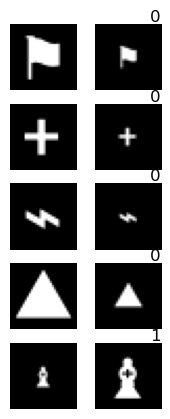

In [13]:
def display_sample(X, y, to_show=10):
    seq_len = int(X.shape[1]/2)
    fig, axarr = plt.subplots(to_show, 2*seq_len, figsize=(2*seq_len, 5))
    plt.rcParams['axes.titlepad'] = -14  
    for i in range(to_show):
        ind = np.random.choice(range(len(X)), 1)[0]
        for j in range(2*seq_len):
            axarr[i,j].imshow(X[ind,j], cmap='gray_r')
            axarr[i,j].axis('off')
            if (j == 2*seq_len-1):
                axarr[i,j].set_title('%d' % y[ind], loc='right')
    plt.show()


display_sample(X, y, to_show=5)

## CNN Encoder (for all models)

In [14]:
class CnnEncoder(tf.keras.Model):
    def __init__(self, ff_dim1=64, ff_dim2=64, normalize=True, name='cnn_encoder'):
        super().__init__(name=name)

        self.conv_layer1 = layers.Conv2D(32, (3, 3), activation='relu', name='%s/conv_layer1' % name)
        self.pool_layer1 = layers.MaxPooling2D((3, 3))
        self.conv_layer2 = layers.Conv2D(32, (3, 3), activation='relu', name='%s/conv_layer2' % name)
        self.pool_layer2 = layers.MaxPooling2D((3, 3))
        self.flatten = layers.Flatten()
        #self.dense1 = layers.Dense(ff_dim1, activation='relu')
        self.dense2 = layers.Dense(ff_dim2, activation='tanh', name='%s/dense_layer' % name)
        if normalize:
            self.normalize = layers.LayerNormalization(center=False, scale=False, epsilon=1e-6)
        else:
            self.normalize = False

    def call(self, inputs):
        source = inputs
        x = self.conv_layer1(source)
        x = self.pool_layer1(x)
        x = self.conv_layer2(x)
        x = self.pool_layer2(x)
        x = self.flatten(x)
        #x = self.dense1(x)
        x = self.dense2(x)
        if self.normalize:
            outputs = self.normalize(x)
        else:
            outputs = x
        return outputs
    
    def print_summary(self, input_shape):
        inputs = layers.Input(input_shape)
        outputs = self.call(inputs)
        print(tf.keras.Model(inputs, outputs).summary())

## Abstractor

In [15]:
from abstracters import SimpleAbstractor, RelationalAbstracter
from abstractor import Abstractor
from tensorflow.keras import layers

In [16]:
embedding_dim = 64

abstractor_kwargs = dict(
        num_layers=1,
        rel_dim=1,
        symbol_dim=10,
        proj_dim=64,
        symmetric_rels=False,
        encoder_kwargs=None,
        rel_activation_type='softmax',
        use_self_attn=False,
        use_layer_norm=False,
        dropout_rate=0.1,)

cnn_encoder_kwargs = dict(ff_dim2=embedding_dim, normalize=False, name='cnn_encoder')

rmtsabstractor_kwargs = dict(cnn_encoder_kwargs=cnn_encoder_kwargs, abstractor_kwargs=abstractor_kwargs)

class AbstractorRMTSModel(tf.keras.Model):
    def __init__(self, cnn_encoder_kwargs, abstractor_kwargs, name=None):
        super().__init__(name=name)
        self.cnn_encoder = CnnEncoder(**cnn_encoder_kwargs)
        # self.cnn_embedder = layers.TimeDistributed(cnn_encoder, name='cnn_embedder')
        self.cnn_encoder.trainable = False
        # self.abstractor = SimpleAbstractor(**abstractor_kwargs)
        self.abstractor = Abstractor(**abstractor_kwargs)
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
    
    def call(self, inputs):
        x = tf.map_fn(self.cnn_encoder, inputs)
        x = self.abstractor(x)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)
# create_opt = lambda : tf.keras.optimizers.Adam()

abstractor_model = AbstractorRMTSModel(**rmtsabstractor_kwargs, name='rmts_abstractor')
abstractor_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
abstractor_model(X_train[:32])
abstractor_model.summary()

2023-05-15 21:18:25.688965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 21:18:26.393483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22296 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1c:00.0, compute capability: 8.6
2023-05-15 21:18:27.570535: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-05-15 21:18:28.585684: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-05-15 21:18:28.652976: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas ex

Model: "rmts_abstractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CnnEncoder)    multiple                  17824     
                                                                 
 abstractor (Abstractor)     multiple                  8450      
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 hidden_layer (Dense)        multiple                  672       
                                                                 
 final_layer (Dense)         multiple                  33        
                                                                 
Total params: 26,979
Trainable params: 9,155
Non-trainable params: 17,824
_________________________________________________________________


In [17]:
train_size = 10
X_train_, y_train_ = X_train[:train_size], y_train[:train_size]
history = abstractor_model.fit(X_train_, y_train_, validation_data=(X_train_, y_train_),
    verbose=1, epochs=20, batch_size=64)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.7536 - binary_accuracy: 0.5000 - val_loss: 0.7473 - val_binary_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 53ms/step - loss: 0.7249 - binary_accuracy: 0.5000 - val_loss: 0.7382 - val_binary_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 0s 60ms/step - loss: 0.7594 - binary_accuracy: 0.5000 - val_loss: 0.7294 - val_binary_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 60ms/step - loss: 0.6994 - binary_accuracy: 0.5000 - val_loss: 0.7212 - val_binary_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 0s 60ms/step - loss: 0.7176 - binary_accuracy: 0.5000 - val_loss: 0.7139 - val_binary_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 0s 55ms/step - loss: 0.7473 - binary_accuracy: 0.5000 - val_loss: 0.7070 - val_binary_accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 0s 57ms/step - loss: 0.7064 - bina

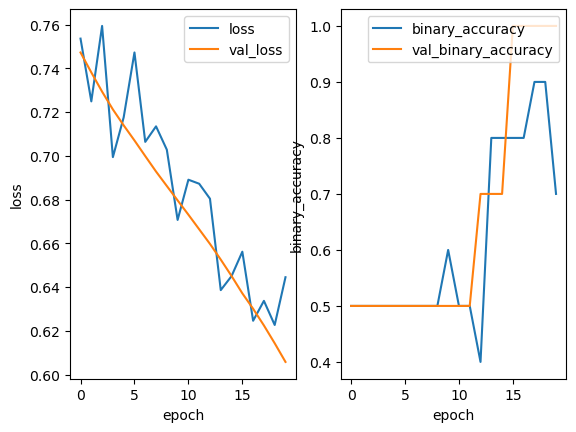

In [18]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [19]:
abstractor_model.evaluate(X_train, y_train)

4/4 [==============================] - 0s 18ms/step - loss: 0.6272 - binary_accuracy: 0.9000


[0.6271562576293945, 0.8999999761581421]

In [20]:
abstractor_model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 14ms/step - loss: 0.6387 - binary_accuracy: 0.8286


[0.6387030482292175, 0.8285714387893677]

## CorelNet

In [21]:
from multi_head_relation import MultiHeadRelation
from tensorflow.keras import layers

In [22]:
embedding_dim = 64
cnn_encoder_kwargs = dict(ff_dim2=embedding_dim, normalize=False, name='cnn_encoder')
rmtscorelnet_kwargs = dict(cnn_encoder_kwargs=cnn_encoder_kwargs)

class CorelNetRMTSModel(tf.keras.Model):
    def __init__(self, cnn_encoder_kwargs, name=None):
        super().__init__(name=name)
        self.cnn_encoder = CnnEncoder(**cnn_encoder_kwargs)
        # self.cnn_embedder = layers.TimeDistributed(cnn_encoder, name='cnn_embedder')
        self.cnn_encoder.trainable = False
        self.flatten = layers.Flatten()
        self.hidden_dense = layers.Dense(32, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
    
    def call(self, inputs):
        x = tf.map_fn(self.cnn_encoder, inputs)
        x = tf.matmul(x, x, transpose_b=True)
        x = self.flatten(x)
        x = self.hidden_dense(x)
        x = self.final_layer(x)

        return x

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

corelnet_model = CorelNetRMTSModel(**rmtscorelnet_kwargs, name='rmts_corelnet')
corelnet_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
corelnet_model(X_train[:32])
corelnet_model.summary()

Model: "rmts_corelnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CnnEncoder)    multiple                  17824     
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 hidden_layer (Dense)        multiple                  160       
                                                                 
 final_layer (Dense)         multiple                  33        
                                                                 
Total params: 18,017
Trainable params: 193
Non-trainable params: 17,824
_________________________________________________________________


In [23]:
train_size = 10
X_train_, y_train_ = X_train[:train_size], y_train[:train_size]
history = corelnet_model.fit(X_train_, y_train_, validation_data=(X_train_, y_train_),
    verbose=1, epochs=20, batch_size=64)

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.6902 - binary_accuracy: 0.5000 - val_loss: 0.6889 - val_binary_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 55ms/step - loss: 0.6889 - binary_accuracy: 0.5000 - val_loss: 0.6877 - val_binary_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 0s 55ms/step - loss: 0.6877 - binary_accuracy: 0.5000 - val_loss: 0.6867 - val_binary_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 56ms/step - loss: 0.6867 - binary_accuracy: 0.5000 - val_loss: 0.6859 - val_binary_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 0s 58ms/step - loss: 0.6859 - binary_accuracy: 0.5000 - val_loss: 0.6852 - val_binary_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 0.6852 - binary_accuracy: 0.5000 - val_loss: 0.6847 - val_binary_accuracy: 0.6000
Epoch 7/20
1/1 [==============================] - 0s 54ms/step - loss: 0.6847 - bina

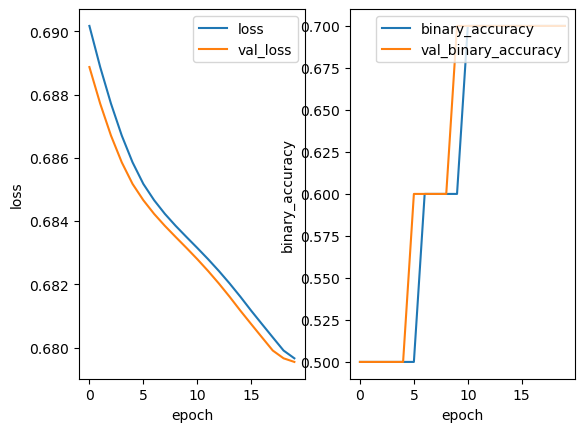

In [24]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [25]:
corelnet_model.evaluate(X_train, y_train)

4/4 [==============================] - 0s 15ms/step - loss: 0.6986 - binary_accuracy: 0.5500


[0.698609471321106, 0.550000011920929]

In [26]:
corelnet_model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 16ms/step - loss: 0.6984 - binary_accuracy: 0.5429


[0.6983519196510315, 0.5428571701049805]

## Transformer

In [27]:
from transformer_modules import Encoder
from tensorflow.keras import layers

In [37]:

embedding_dim = 64
encoder_kwargs = dict(
    num_layers=1, 
    num_heads=4,
    dff=64,
    dropout_rate=0.1)

cnn_encoder_kwargs = dict(ff_dim2=embedding_dim, normalize=False, name='cnn_encoder')
rmtstransformer_kwargs = dict(cnn_encoder_kwargs=cnn_encoder_kwargs, encoder_kwargs=encoder_kwargs)

class TransformerRMTSModel(tf.keras.Model):
    def __init__(self, cnn_encoder_kwargs, encoder_kwargs, name=None):
        super().__init__(name=name)
        self.cnn_encoder = CnnEncoder(**cnn_encoder_kwargs)
        # self.cnn_embedder = layers.TimeDistributed(self.cnn_encoder, name='cnn_embedder')
        # self.cnn_encoder.trainable = False
        self.encoder = Encoder(**encoder_kwargs)
        self.flatten = layers.Flatten()
        self.hidden_dense1 = layers.Dense(64, activation='relu', name='hidden_layer')
        self.hidden_dense2 = layers.Dense(64, activation='relu', name='hidden_layer')
        self.final_layer = layers.Dense(1, activation='sigmoid', name='final_layer')
    
    def call(self, inputs):
        # x = self.cnn_embedder(inputs)
        x = tf.map_fn(self.cnn_encoder, inputs)
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.hidden_dense1(x)
        x = self.hidden_dense2(x)
        x = self.final_layer(x)

        return x

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.01)
# create_opt = lambda : tf.keras.optimizers.SGD(learning_rate=0.01)

transformer_model = TransformerRMTSModel(**rmtstransformer_kwargs, name='rmts_transformer')
transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
transformer_model(X_train[:32])
transformer_model.summary()

Model: "rmts_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_encoder (CnnEncoder)    multiple                  17824     
                                                                 
 encoder (Encoder)           multiple                  74944     
                                                                 
 flatten_11 (Flatten)        multiple                  0         
                                                                 
 hidden_layer (Dense)        multiple                  8256      
                                                                 
 hidden_layer (Dense)        multiple                  4160      
                                                                 
 final_layer (Dense)         multiple                  65        
                                                                 
Total params: 105,249
Trainable params: 105,249
No

In [38]:
train_size = 10
X_train_, y_train_ = X_train[:train_size], y_train[:train_size]
history = transformer_model.fit(X_train_, y_train_, validation_data=(X_train_, y_train_),
    verbose=1, epochs=40, batch_size=64)

Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.7347 - binary_accuracy: 0.5000 - val_loss: 0.6877 - val_binary_accuracy: 0.5000
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.6989 - binary_accuracy: 0.5000 - val_loss: 0.7725 - val_binary_accuracy: 0.5000
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.7798 - binary_accuracy: 0.5000 - val_loss: 1.2982 - val_binary_accuracy: 0.5000
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 1.3030 - binary_accuracy: 0.5000 - val_loss: 0.7465 - val_binary_accuracy: 0.5000
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.7471 - binary_accuracy: 0.5000 - val_loss: 0.7116 - val_binary_accuracy: 0.5000
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.7107 - binary_accuracy: 0.5000 - val_loss: 0.7256 - val_binary_accuracy: 0.5000
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.7149 - bina

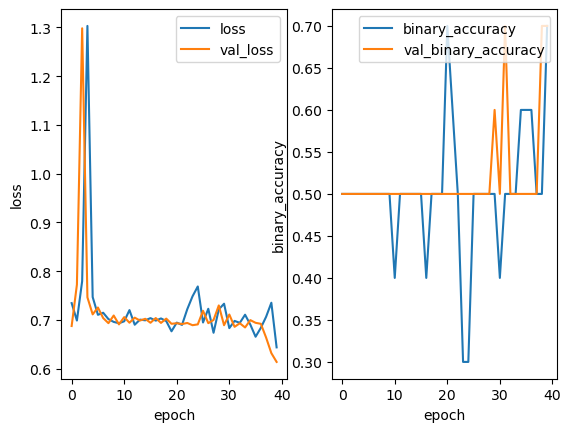

In [39]:
utils.plot_history(history, ('loss', 'binary_accuracy'));

In [40]:
transformer_model.evaluate(X_train, y_train);

4/4 [==============================] - 0s 20ms/step - loss: 0.6508 - binary_accuracy: 0.6200


In [41]:
transformer_model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 15ms/step - loss: 0.6761 - binary_accuracy: 0.5143


[0.6760765314102173, 0.5142857432365417]

## Learning curve evaluation

In [42]:
def create_callbacks(use_wandb=False, patience=10):
    callbacks = []
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
        patience=patience, min_delta=1e-2, baseline=0.6, mode='auto',
        restore_best_weights=True, verbose=False))
    if use_wandb: callbacks.append(wandb.keras.WandbMetricsLogger(log_freq='epoch'))
    return callbacks

def evaluate_model(model, X_test, y_test):
    eval_dict = model.evaluate(X_test, y_test, return_dict=True, verbose=False)
    return eval_dict

def log_to_wandb(evaluation_dict):
    wandb.log(evaluation_dict)

In [43]:
start_trial = 0
wandb_project_name = 'abstractor_size_rmts'

fit_kwargs = {'epochs': 100, 'batch_size': 64}

def evaluate_learning_curves(
    create_model, group_name, 
    X_train, y_train, X_val, y_val, X_test, y_test,
    train_sizes, num_trials, use_wandb=False):

    eval_dicts =[]

    for train_size in tqdm(train_sizes, desc='train size'):

        for trial in trange(start_trial, start_trial + num_trials, desc='trial', leave=False):

            if use_wandb:
                run = wandb.init(project=wandb_project_name, group=group_name, name=f'train size = {train_size}; trial = {trial}',
                    config={'train size': train_size, 'trial': trial, 'group': group_name})
            model = create_model()

            sample_idx = np.random.choice(len(X_train), train_size, replace=False)
            X_train_ = X_train[sample_idx]
            y_train_ = y_train[sample_idx]
            
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=0,
                callbacks=create_callbacks(use_wandb=use_wandb), **fit_kwargs)

            eval_dict = evaluate_model(model, X_test, y_test)
            
            if use_wandb:
                log_to_wandb(eval_dict)
                wandb.finish(quiet=True)
            
            eval_dict.update({'group': group_name, 'train_size': train_size, 'trial': trial})
            eval_dicts.append(eval_dict)

            del model
    
    return eval_dicts


In [44]:
def create_abstractor():
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
    create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

    abstractor_model = AbstractorRMTSModel(**rmtsabstractor_kwargs, name='rmts_abstractor')
    abstractor_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
    abstractor_model(X_train[:32])

    return abstractor_model

def create_corelnet():
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
    create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

    corelnet_model = CorelNetRMTSModel(**rmtscorelnet_kwargs, name='rmts_corelnet')
    corelnet_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
    corelnet_model(X_train[:32])
    return corelnet_model

def create_transformer():
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
    create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)

    transformer_model = TransformerRMTSModel(**rmtstransformer_kwargs, name='rmts_transformer')
    transformer_model.compile(loss='binary_crossentropy', optimizer=create_opt(), metrics=['binary_accuracy'])
    transformer_model(X_train[:32])
    return transformer_model


In [45]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin


True

In [46]:
num_trials = 1
train_sizes = [5, 10, 20, 30, 40]

print('evaluating abstractor')

abstractor_eval_dicts = evaluate_learning_curves(
    create_abstractor, 'abstractor', 
    X_train, y_train, X_val, y_val, X_test, y_test,
    train_sizes, num_trials, use_wandb=False)

print('evaluating corelnet')

corelnet_eval_dicts = evaluate_learning_curves(
    create_corelnet, 'corelnet', 
    X_train, y_train, X_val, y_val, X_test, y_test,
    train_sizes, num_trials, use_wandb=False)

print('evaluating transformer')

transformer_eval_dicts = evaluate_learning_curves(
    create_transformer, 'transformer', 
    X_train, y_train, X_val, y_val, X_test, y_test,
    train_sizes, num_trials, use_wandb=False)

evaluating abstractor


train size: 100%|██████████| 5/5 [00:24<00:00,  4.99s/it]


evaluating corelnet


train size: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


evaluating transformer


train size: 100%|██████████| 5/5 [00:39<00:00,  7.85s/it]


In [47]:
import pandas as pd
dfs = [pd.DataFrame(eval_dict) for eval_dict in (abstractor_eval_dicts, corelnet_eval_dicts, transformer_eval_dicts)]
pd.concat(dfs)

,loss,binary_accuracy,group,train_size,trial
0,0.022509,1.000000,abstractor,5,0
1,0.619966,1.000000,abstractor,10,0
2,0.613458,0.914286,abstractor,20,0
3,0.027017,1.000000,abstractor,30,0
4,0.611699,0.671429,abstractor,40,0
0,0.712416,0.471429,corelnet,5,0
1,0.688291,0.814286,corelnet,10,0
2,0.703540,0.471429,corelnet,20,0
3,0.753636,0.471429,corelnet,30,0
4,0.634969,0.828571,corelnet,40,0
